In [1]:
!pip install hmmlearn yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.8 MB/s eta 0:00:00


[*********************100%%**********************]  6 of 6 completed



Determined Optimal Weights :
       Weights
AAPL  0.230699
GOOG  0.260781
TSLA  0.077052
MSFT  0.050028
AMZN  0.207361
HCL   0.174080


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Portfolio expected return:  2.0306565578558438
Portfolio risk is : 12.718811555998379

Expected Return and Risk:
      Expected Return       Risk
AAPL         0.106404   2.792233
GOOG         0.103830   1.934590
TSLA         0.198497   3.581400
MSFT         0.109290   2.115380
AMZN         0.172094   3.551148
HCL         11.044290  72.783984

Correlation Coefficients:
          AAPL      GOOG      TSLA      MSFT      AMZN       HCL
AAPL  1.000000  0.550393  0.357196  0.586446  0.481185  0.020151
GOOG  0.550393  1.000000  0.322652  0.639038  0.598883  0.014663
TSLA  0.357196  0.322652  1.000000  0.345243  0.346265  0.011808
MSFT  0.586446  0.639038  0.345243  1.000000  0.566921  0.013611
AMZN  0.481185  0.598883  0.346265  0.566921  1.000000  0.004000
HCL   0.020151  0.014663  0.011808  0.013611  0.004000  1.000000


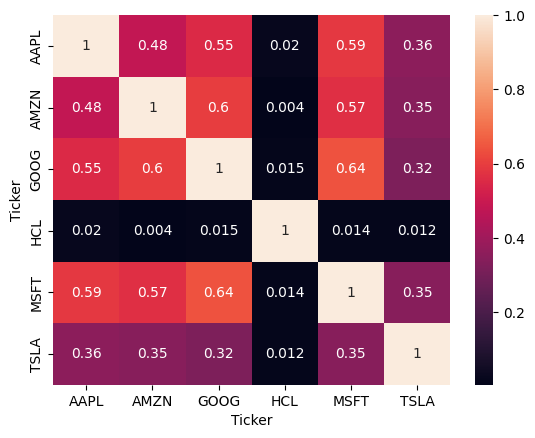

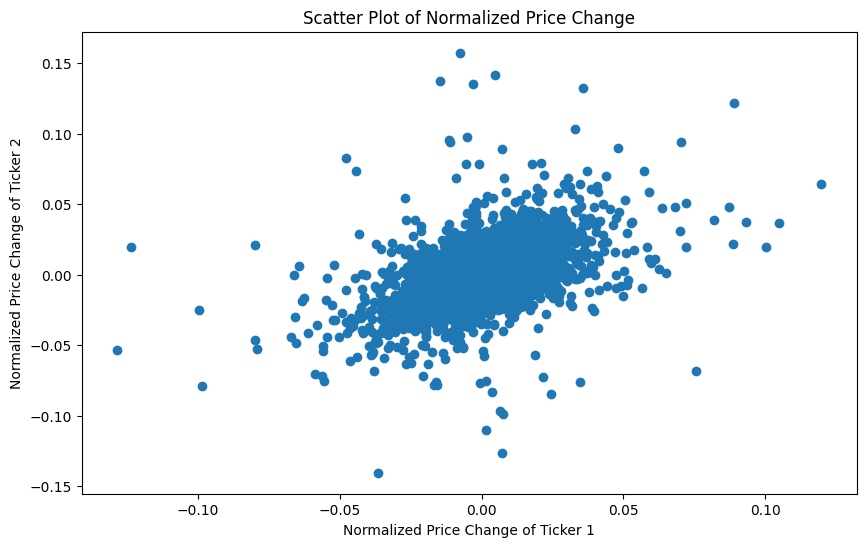


GMM Metrics:
Log-Likelihood: 18.808280429161176
BIC: -129988.37896675298
AIC: -131362.42924756152


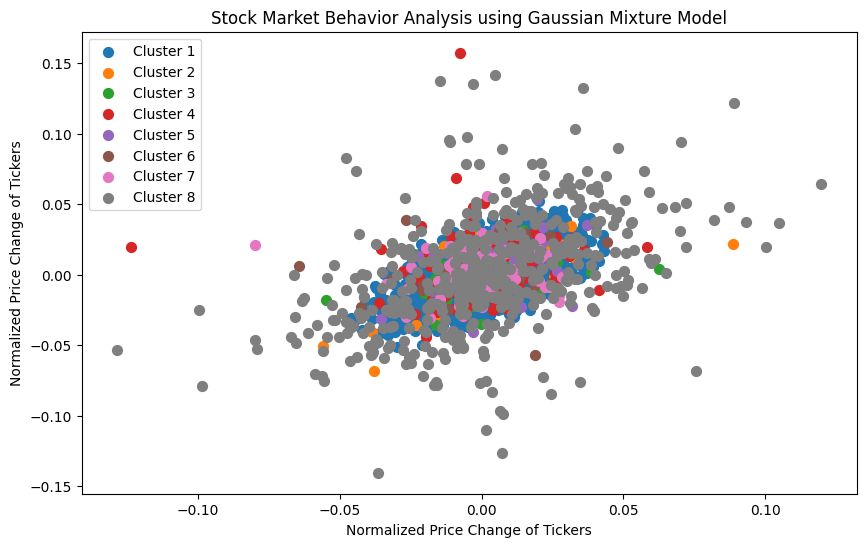


Gaussian HMM Metrics:
Log-Likelihood: 61194.42066776254
BIC: -121556.35196941534
AIC: -122184.84133552508


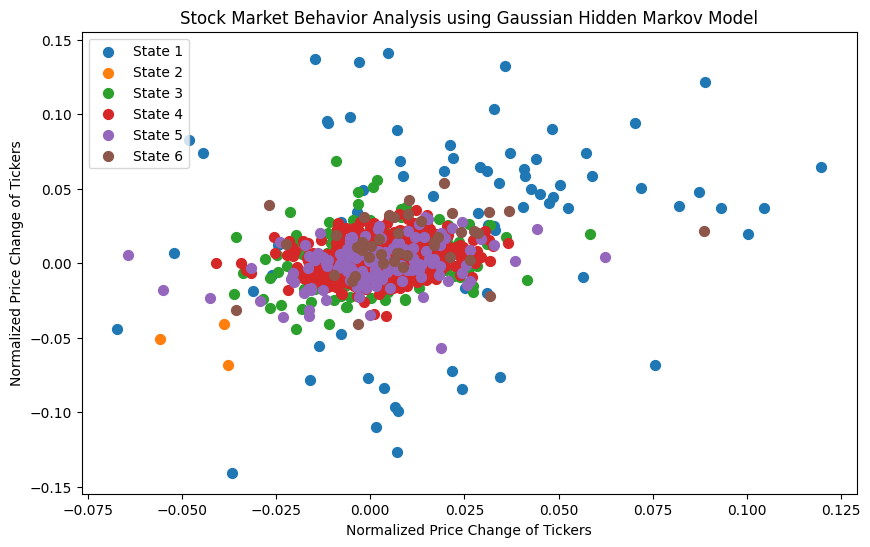

In [2]:
import yfinance as yf
import scipy.optimize as sco
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbols
tickers = ['AAPL', 'GOOG', 'TSLA', 'MSFT', 'AMZN', 'HCL']

class Statistics:
    def __init__(self, lst):
        self.lst = lst

    def mean(self):
        return sum(self.lst) / len(self.lst)

    def var(self):
        x_bar = self.mean()
        return sum((x - x_bar) ** 2 for x in self.lst) / len(self.lst)

    def stdev(self):
        return self.var() ** 0.5


class Portfolio:
    def __init__(self, n_companies, weights, ticker):
        self.n_companies = n_companies
        self.weights = weights
        self.ticker = ticker
        self.returns, self.exp_return, self.risk = self.risk_return_individual()

    def risk_return_individual(self):
        returns = []
        exp_return = []
        risk = []
        for ticker in self.ticker:
            data = yf.download(ticker, period='max', interval='1d')
            lst = data['Close']
            ret = [(lst[j + 1] - lst[j]) / lst[j] * 100 for j in range(len(lst) - 1)]
            ret_stats = Statistics(ret)
            returns.append(ret)
            exp_return.append(ret_stats.mean())
            risk.append(ret_stats.stdev())
        return returns, exp_return, risk

    def portfolio_return(self):
        port_returns = sum(a * b for a, b in zip(self.weights, self.exp_return))
        print('Portfolio expected return: ', port_returns)

    def portfolio_risk(self):
        term_1 = sum([w*w*r*r for w, r in zip(self.weights,self.risk)])
        cov_matrix = np.zeros((self.n_companies,self.n_companies))
        for i in range(self.n_companies):
            for j in range(self.n_companies):
                returns_i = pd.Series(self.returns[i])
                returns_j = pd.Series(self.returns[j])
                cov_matrix[i][j] = returns_i.cov(returns_j)

        term_2 = 2*(sum([self.weights[i]*self.weights[j]*cov_matrix[i][j] for i in range(self.n_companies) for j in range(i+1, self.n_companies)]))
        port_risk = (term_1 + term_2)**0.5
        print('Portfolio risk is :', port_risk)


# Download historical stock prices
data = yf.download(tickers, period='max', interval='1d')['Close']
returns = data.pct_change().dropna()

# Calculate expected returns and covariance matrix
expected_returns = returns.mean()
covariance_matrix = returns.cov()

# Define objective function and constraints
def objective(weights):
    portfolio_return = np.dot(weights.T, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio

constraints = [{'type': 'eq', 'fun': lambda a: np.sum(a) - 1}]  # Constraint: sum of weights equals 1
bounds = [(0, 1) for _ in tickers]  # Bounds: each weight between 0 and 1

# Find optimal weights using optimization
initial_weights = np.ones(len(tickers)) / len(tickers)  # Initial guess: equal weights
result = sco.minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Get determined optimal weights
optimal_weights = result.x

weights_df = pd.DataFrame(optimal_weights, index=tickers, columns=['Weights'])
print('\nDetermined Optimal Weights :')
print(weights_df)

# Create Portfolio object
portfolio = Portfolio(len(tickers), optimal_weights, tickers)

# Calculate portfolio return and risk
portfolio.portfolio_return()
portfolio.portfolio_risk()

# Retrieve expected returns and risks corresponding to tickers
exp_return = portfolio.exp_return
risk = portfolio.risk
ret_risk_df = pd.DataFrame({'Expected Return': exp_return, 'Risk': risk}, index=tickers)
print("\nExpected Return and Risk:")
print(ret_risk_df)

# Calculate correlation matrix
correlation_matrix = returns.corr()

# Calculate correlation coefficients
correlation_coefficients = pd.DataFrame(correlation_matrix, columns=tickers, index=tickers)
print("\nCorrelation Coefficients:")
print(correlation_coefficients)

# Heatmap
sns.heatmap(correlation_matrix, annot=True)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(returns.iloc[:, 0], returns.iloc[:, 1])
plt.xlabel('Normalized Price Change of Ticker 1')
plt.ylabel('Normalized Price Change of Ticker 2')
plt.title('Scatter Plot of Normalized Price Change')
plt.show()

# Check how many regimes we should have optimally
n_com = np.arange(1, 11)
models = [GaussianMixture(n_components=n, random_state=0).fit(returns) for n in n_com]
optimal_n_components_gmm = n_com[np.argmin([m.bic(returns) for m in models])]
gmm_model = GaussianMixture(n_components=optimal_n_components_gmm, random_state=0).fit(returns)

# Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_n_components_gmm)
gmm.fit(returns)

# Predict the clusters for each data point
labels = gmm.predict(returns)

# Calculate log-likelihood
log_likelihood = gmm.score(returns)

# Calculate BIC
gmm_bic = gmm.bic(returns)

# Calculate AIC
gmm_aic = gmm.aic(returns)

# Print the metrics
print("\nGMM Metrics:")
print("Log-Likelihood:", log_likelihood)
print("BIC:", gmm_bic)
print("AIC:", gmm_aic)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(gmm.n_components):
    plt.scatter(returns.iloc[labels == i, 0], returns.iloc[labels == i, 1], s=50, label=f'Cluster {i + 1}')
plt.legend()
plt.xlabel('Normalized Price Change of Tickers')
plt.ylabel('Normalized Price Change of Tickers')
plt.title('Stock Market Behavior Analysis using Gaussian Mixture Model')
plt.show()

# Check how many regimes we should have optimally
n_com = np.arange(1, 11)
models = [GaussianHMM(n_components=n, random_state=0).fit(returns) for n in n_com]

n_features = returns.shape[1]
log_likelihoods = [model.score(returns) for model in models]
n_params = [n * (n - 1) + 2 * n * n_features for n in n_com]
bic_values = [-2 * ll + np.log(n) * n for ll, n in zip(log_likelihoods, n_params)]

optimal_n_components_hmm = n_com[np.argmin(bic_values)]
hmm_model = GaussianHMM(n_components=optimal_n_components_hmm, random_state=0).fit(returns)

# GaussianHMM
n_states = 6
hmm = GaussianHMM(n_components=optimal_n_components_hmm)
hmm.fit(returns)

# Predict the hidden states for each data point
hidden_states = hmm.predict(returns)

# Calculate log-likelihood
log_likelihood = hmm.score(returns)

# Calculate the number of parameters
n_features = returns.shape[1]
n_params = n_states * (n_states - 1) + 2 * n_states * n_features

# Calculate BIC
hmm_bic = -2 * log_likelihood + n_params * np.log(len(returns))

# Calculate AIC
hmm_aic = -2 * log_likelihood + 2 * n_params

# Print the metrics
print("\nGaussian HMM Metrics:")
print("Log-Likelihood:", log_likelihood)
print("BIC:", hmm_bic)
print("AIC:", hmm_aic)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(n_states):
    plt.scatter(returns.iloc[hidden_states == i, 0], returns.iloc[hidden_states == i, 1], s=50, label=f'State {i + 1}')
plt.legend()
plt.xlabel('Normalized Price Change of Tickers')
plt.ylabel('Normalized Price Change of Tickers')
plt.title('Stock Market Behavior Analysis using Gaussian Hidden Markov Model')
plt.show()